In [1]:
import tensorflow as tf
import pandas
import konlpy
import gensim

print(tf.__version__)
print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.6.0
1.3.3
0.5.2
4.1.2


# 1)데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.shape

(150000, 3)

# 2)데이터 로더 구성
- 데이터의 중복 제거<br>
- NaN 결측치 제거<br>
- 한국어 토크나이저로 토큰화<br>
- 불용어(Stopwords) 제거<br>
- 사전word_to_index 구성<br>
- 텍스트 스트링을 사전 인덱스 스트링으로 변환<br>
- X_train, y_train, X_test, y_test, word_to_index 리턴<br>

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
   
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
len(X_test)

49157

In [6]:
len(y_test)

49157

### word_to_index, index_to_word에 PAD, BOS, UNK 추가

In [7]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3)모델 구성을 위한 데이터 분석 및 가공
 - 데이터셋 내 문장 길이 분포<br>
 - 적절한 최대 문장 길이 지정<br>
 - keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가<br>

- X_train 데이터와 X_test 데이터에 시작 \<BOS\> 정보를 모두 붙여넣어줍니다<br>
- 나중에 예측할때 시작점을 넣어주는게 정상적으로 예측할것같아서<br>

In [10]:
for sentense in X_train:
    sentense.insert(0,word_to_index["<BOS>"])
for sentense in X_test:
    sentense.insert(0,word_to_index["<BOS>"])

In [11]:
X_train[0]

[1, 32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [12]:
X_test[0]

[1, 832, 130]

In [13]:
print(get_decoded_sentence(X_train[0], index_to_word))
print(y_train[0])

아 더 빙 . . 진짜 짜증 나 네요 목소리
0


In [14]:
print(get_decoded_sentence(X_test[0], index_to_word))
print(y_test[0])

굳 ㅋ
1


In [15]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  16.96940191154864
문장길이 최대 :  117
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  42
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape,x_test.shape)

(146182, 42) (49157, 42)


In [17]:
print(x_train)

[[   0    0    0 ...   20   33  748]
 [   0    0    0 ...   15   44  391]
 [   0    0    0 ...   24  205    3]
 ...
 [   0    0    0 ... 2710    6   18]
 [   0    0    0 ...   60  395 8572]
 [   0    0    0 ...   88 2740    5]]


# 4)모델 구성 및 validation set 구성

In [18]:
from sklearn.model_selection import train_test_split
xx_train, xx_val, yy_train, yy_val = \
    train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(xx_train.shape,yy_train.shape)
print(xx_val.shape,yy_val.shape)

(116945, 42) (116945,)
(29237, 42) (29237,)


### model1: LSTM

In [19]:
def get_embedding_size(num_categories):

    if num_categories <= 1000 :
        embedding_dimensions = min(500, num_categories/2)
    # num_categories > 1000 일때
    else:
        embedding_dimensions = 75.6496 * np.log(num_categories + 176.623) - 41.4457
    
    return int(embedding_dimensions)

def get_hidden_size(n_input, n_output, n_sample, alpha=2):
    n_hidden = n_sample / (alpha*(n_input + n_output))
    return int(n_hidden)

In [20]:
train_samples = xx_train.shape[0]
vocab_size =len(index_to_word)
word_vector_dim = get_embedding_size(vocab_size)  
hidden_size = get_hidden_size(n_input=word_vector_dim,
                               n_output=vocab_size, 
                               n_sample=train_samples*word_vector_dim)
hidden_size = 125
input_data_length = maxlen
print('train_samples=',train_samples)
print('vocab_size=',vocab_size)
print('word_vector_dim=',word_vector_dim)
print('hidden_size=',hidden_size)
print('input_data_length=',input_data_length)

train_samples= 116945
vocab_size= 10000
word_vector_dim= 656
hidden_size= 125
input_data_length= 42


In [22]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim=word_vector_dim,
                                    input_length=input_data_length))

model1.add(tf.keras.layers.LSTM(units = hidden_size,return_sequences=True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model1.add(tf.keras.layers.LSTM(units = hidden_size))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model1.add(tf.keras.layers.Dense(units= vocab_size, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 42, 656)           6560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 42, 125)           391000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 125)               125500    
_________________________________________________________________
dense (Dense)                (None, 10000)             1260000   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 8,346,501
Trainable params: 8,346,501
Non-trainable params: 0
_________________________________________________________________


### model2: Convolution Neural Network

In [23]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 656)         6560000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          73488     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### model3: GlobalMaxPooling1D

In [24]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 656)         6560000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 656)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 5256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 6,565,265
Trainable params: 6,565,265
Non-trainable params: 0
_________________________________________________________________


# 5)모델별 훈련 개시

###  model1.fit() LSTM

In [25]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(xx_train,
                    yy_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(xx_val, yy_val),
                    verbose=1)

Epoch 1/10
115/115 [==============================] - 12s 72ms/step - loss: 0.4181 - accuracy: 0.8009 - val_loss: 0.3613 - val_accuracy: 0.8438
Epoch 2/10
115/115 [==============================] - 8s 68ms/step - loss: 0.3097 - accuracy: 0.8677 - val_loss: 0.3378 - val_accuracy: 0.8523
Epoch 3/10
115/115 [==============================] - 8s 69ms/step - loss: 0.2655 - accuracy: 0.8872 - val_loss: 0.3429 - val_accuracy: 0.8518
Epoch 4/10
115/115 [==============================] - 8s 71ms/step - loss: 0.2257 - accuracy: 0.9054 - val_loss: 0.3634 - val_accuracy: 0.8517
Epoch 5/10
115/115 [==============================] - 8s 71ms/step - loss: 0.1921 - accuracy: 0.9201 - val_loss: 0.4203 - val_accuracy: 0.8507
Epoch 6/10
115/115 [==============================] - 8s 72ms/step - loss: 0.1627 - accuracy: 0.9338 - val_loss: 0.4931 - val_accuracy: 0.8463
Epoch 7/10
115/115 [==============================] - 8s 73ms/step - loss: 0.1398 - accuracy: 0.9437 - val_loss: 0.5363 - val_accuracy: 0.845

In [26]:
results = model1.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.6901 - accuracy: 0.8354
[0.6900585889816284, 0.8354049324989319]


###  model2.fit() Convolution Neural Network

In [27]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(xx_train,
                    yy_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(xx_val, yy_val),
                    verbose=1)

Epoch 1/4
229/229 [==============================] - 5s 16ms/step - loss: 0.4406 - accuracy: 0.7841 - val_loss: 0.3517 - val_accuracy: 0.8427
Epoch 2/4
229/229 [==============================] - 3s 14ms/step - loss: 0.3041 - accuracy: 0.8702 - val_loss: 0.3430 - val_accuracy: 0.8483
Epoch 3/4
229/229 [==============================] - 3s 14ms/step - loss: 0.2305 - accuracy: 0.9069 - val_loss: 0.3692 - val_accuracy: 0.8431
Epoch 4/4
229/229 [==============================] - 3s 14ms/step - loss: 0.1503 - accuracy: 0.9441 - val_loss: 0.4439 - val_accuracy: 0.8359


In [28]:
results = model2.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4455 - accuracy: 0.8328
[0.445515900850296, 0.8327603340148926]


### model3.fit() GlobalMaxPooling1D

In [29]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(xx_train,
                    yy_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(xx_val, yy_val),
                    verbose=1)

Epoch 1/4
229/229 [==============================] - 3s 10ms/step - loss: 0.4290 - accuracy: 0.8155 - val_loss: 0.3421 - val_accuracy: 0.8514
Epoch 2/4
229/229 [==============================] - 2s 9ms/step - loss: 0.2960 - accuracy: 0.8757 - val_loss: 0.3381 - val_accuracy: 0.8544
Epoch 3/4
229/229 [==============================] - 2s 9ms/step - loss: 0.2431 - accuracy: 0.9023 - val_loss: 0.3485 - val_accuracy: 0.8538
Epoch 4/4
229/229 [==============================] - 2s 9ms/step - loss: 0.1895 - accuracy: 0.9297 - val_loss: 0.3738 - val_accuracy: 0.8508


In [30]:
results = model3.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3806 - accuracy: 0.8497
[0.38060587644577026, 0.8496653437614441]


In [31]:
import matplotlib.pyplot as plt
def draw_loss_accuracy_graph(history,txt_model_name):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.subplot(2,1,1)
    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo--', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'ro--', label='Validation loss')
    plt.title(txt_model_name+' Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(2,1,2)
    plt.plot(epochs, acc, 'bo--', label='Training acc')
    plt.plot(epochs, val_acc, 'ro--', label='Validation acc')
    plt.title(txt_model_name+' Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

# 6)Loss,Accuracy 그래프 시각화

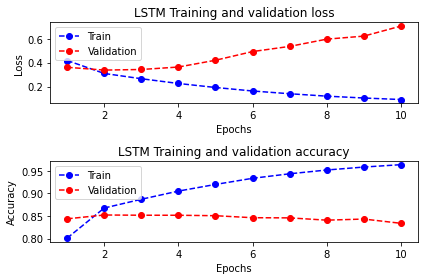

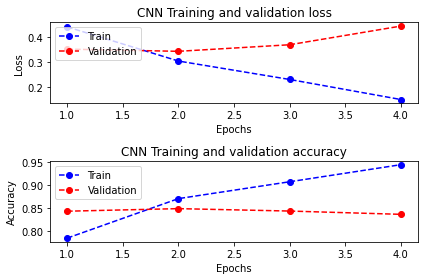

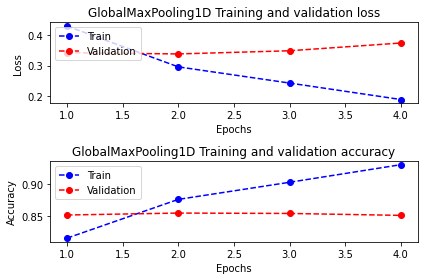

In [32]:
draw_loss_accuracy_graph(history1,'LSTM')
draw_loss_accuracy_graph(history2,'CNN')
draw_loss_accuracy_graph(history3,'GlobalMaxPooling1D')

# 7)학습된 Embedding레이어 분석

### 자체학습 LSTM 모델 임베딩 분석

In [33]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 656)


In [34]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'lstm_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [35]:
word2vec_file_path = 'lstm_word2vec.txt'
from gensim.models.keyedvectors import Word2VecKeyedVectors
print(model1.get_weights()[0])
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
print(word_vectors.vectors.shape)

vector = word_vectors['사랑']
vector

[[-0.00754935 -0.01497225  0.02386746 ... -0.03005902 -0.03804918
  -0.00999823]
 [-0.0039879  -0.0209295   0.00811292 ... -0.03482991  0.01506076
  -0.00507548]
 [ 0.01129926  0.01473563 -0.02142347 ...  0.04511769  0.03395117
  -0.02113849]
 ...
 [ 0.09020939  0.07355179 -0.04081298 ...  0.05222497  0.00558135
   0.02296473]
 [-0.00900477  0.08003215 -0.02920782 ...  0.04378248 -0.06193143
   0.06636756]
 [-0.09651308  0.05246721 -0.06892615 ... -0.03593567  0.0526824
   0.07643785]]
(9996, 656)


array([-6.66585267e-02,  1.58436671e-02,  1.09356701e-01, -2.70678475e-02,
       -3.86014692e-02, -2.13834476e-02, -3.21167894e-02, -2.19529141e-02,
       -1.05855890e-01, -1.82925947e-02,  1.25533165e-02, -6.60136938e-02,
        2.47297771e-02,  1.09796524e-01,  6.70431852e-02, -7.94526115e-02,
       -6.41444772e-02,  1.48351137e-02, -1.69552993e-02, -3.83097827e-02,
       -1.06919259e-02,  4.10568081e-02,  4.38380763e-02,  5.20565314e-03,
       -3.43227945e-02,  2.60748193e-02, -5.90988137e-02, -5.43451756e-02,
       -3.70807536e-02, -3.55538391e-02, -3.96462940e-02,  1.51319318e-02,
        1.02337869e-02, -5.11729382e-02, -2.05824263e-02, -3.38885076e-02,
       -9.81098488e-02, -1.12728015e-01,  8.59265774e-02, -3.01745813e-03,
        3.29891481e-02,  2.15783697e-02,  3.27841491e-02, -5.04747555e-02,
       -6.02433160e-02,  5.75502403e-02, -3.58393788e-02, -2.10296754e-02,
       -3.07198446e-02, -1.03807889e-01, -1.35384928e-02, -4.62661758e-02,
        5.99264912e-02, -

In [36]:
word_vectors.similar_by_word("사랑")

[('설레', 0.7476403117179871),
 ('명작', 0.7421166896820068),
 ('..)', 0.7370077967643738),
 ('수작', 0.7237048149108887),
 ('최고', 0.7160084247589111),
 ('먹먹', 0.713281512260437),
 ('소장', 0.702877402305603),
 ('탄탄', 0.6947634816169739),
 ('부드러운', 0.6925491690635681),
 ('유쾌', 0.690848171710968)]

### 사전학습 임베딩 분석

In [37]:
word2vec_file_path = 'word2vec_ko.model'
from gensim.models.keyedvectors import Word2VecKeyedVectors
print(model1.get_weights()[0])
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
print(type(word_vectors.wv))
vector = word_vectors.wv['사랑']
print(vector.shape)
vector

[[-0.00754935 -0.01497225  0.02386746 ... -0.03005902 -0.03804918
  -0.00999823]
 [-0.0039879  -0.0209295   0.00811292 ... -0.03482991  0.01506076
  -0.00507548]
 [ 0.01129926  0.01473563 -0.02142347 ...  0.04511769  0.03395117
  -0.02113849]
 ...
 [ 0.09020939  0.07355179 -0.04081298 ...  0.05222497  0.00558135
   0.02296473]
 [-0.00900477  0.08003215 -0.02920782 ...  0.04378248 -0.06193143
   0.06636756]
 [-0.09651308  0.05246721 -0.06892615 ... -0.03593567  0.0526824
   0.07643785]]
<class 'gensim.models.keyedvectors.KeyedVectors'>
(100,)


array([ 3.2565942 , -0.85421413, -3.6964011 ,  1.0956469 ,  0.599815  ,
       -1.9681435 ,  0.32379073, -1.0716053 , -1.1776937 ,  2.0442047 ,
        2.2501915 , -2.7868037 , -2.702359  , -0.9775915 , -0.12478333,
        0.28235647,  0.77683175, -1.5393747 ,  2.0879042 , -5.444462  ,
       -4.931412  ,  0.8532094 ,  0.11118065, -2.743522  ,  0.7902363 ,
        0.10469969, -0.56074625,  1.6684421 ,  1.0278419 , -3.8816829 ,
       -3.606887  , -3.120771  , -1.2527398 , -0.77196646, -1.0102901 ,
        3.331668  ,  0.30032924,  1.2074511 , -1.2813627 ,  2.6281219 ,
       -1.4624823 , -1.1354805 ,  0.7605239 ,  2.83577   , -1.199358  ,
        3.1347232 ,  4.062026  , -0.23413125,  3.205856  , -0.9567054 ,
        0.77167803, -1.4300145 ,  2.9014013 , -3.940087  , -3.234169  ,
       -5.5460634 ,  0.6185009 , -0.75793767,  2.1043491 ,  2.350599  ,
        2.9313247 , -2.235593  ,  3.2084036 , -5.594638  ,  1.6516634 ,
       -0.32628602, -1.8824683 , -1.5573231 , -1.8452163 , -1.40

In [38]:
word_vectors.wv.most_similar(positive=['사랑'])

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

# 8)한국어 Word2Vec 임베딩 활용하여 성능개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용<br>
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러오기<br>

In [39]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
cnt=0
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv.index_to_key:
        cnt +=1
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]
print(cnt)

9453


In [40]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model_final = tf.keras.Sequential()
model_final.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model_final.add(tf.keras.layers.LSTM(units = hidden_size,return_sequences=True))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model_final.add(tf.keras.layers.LSTM(units = hidden_size)) 
model_final.add(tf.keras.layers.Dense(units= vocab_size, activation='relu'))
model_final.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_final.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 42, 100)           1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 42, 125)           113000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 125)               125500    
_________________________________________________________________
dense_6 (Dense)              (None, 10000)             1260000   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 10001     
Total params: 2,508,501
Trainable params: 2,508,501
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_final.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_final = model_final.fit(xx_train,
                                yy_train,
                                epochs=epochs,
                                batch_size=1024,
                                validation_data=(xx_val, yy_val),
                                verbose=1)

Epoch 1/10
115/115 [==============================] - 7s 46ms/step - loss: 0.4857 - accuracy: 0.7582 - val_loss: 0.4127 - val_accuracy: 0.8106
Epoch 2/10
115/115 [==============================] - 5s 41ms/step - loss: 0.3710 - accuracy: 0.8352 - val_loss: 0.3902 - val_accuracy: 0.8225
Epoch 3/10
115/115 [==============================] - 5s 41ms/step - loss: 0.3222 - accuracy: 0.8608 - val_loss: 0.3364 - val_accuracy: 0.8529
Epoch 4/10
115/115 [==============================] - 5s 42ms/step - loss: 0.2862 - accuracy: 0.8781 - val_loss: 0.3299 - val_accuracy: 0.8576
Epoch 5/10
115/115 [==============================] - 5s 42ms/step - loss: 0.2669 - accuracy: 0.8880 - val_loss: 0.3413 - val_accuracy: 0.8605
Epoch 6/10
115/115 [==============================] - 5s 42ms/step - loss: 0.2404 - accuracy: 0.9001 - val_loss: 0.3553 - val_accuracy: 0.8492
Epoch 7/10
115/115 [==============================] - 5s 43ms/step - loss: 0.2204 - accuracy: 0.9102 - val_loss: 0.3320 - val_accuracy: 0.8615

In [42]:
# 테스트셋을 통한 모델 평가
results = model_final.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4188 - accuracy: 0.8550
[0.41882359981536865, 0.8550155758857727]


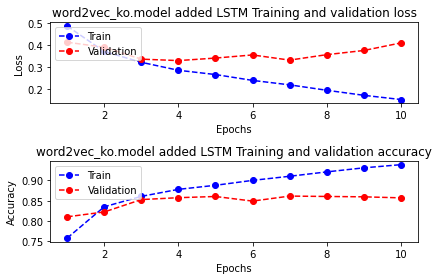

In [43]:
draw_loss_accuracy_graph(history_final,'word2vec_ko.model added LSTM')